# Open-loop optimal control of a simple pendulum using single-shooting

In this notebook, we will perform open-loop optimal control of a simple pendulum using the single-shooting method in CasADi. The single-shooting method involves integrating the entire system dynamics over the time horizon using the control inputs as optimization variables.

First, we will define the pendulum model and the necessary functions for integration and simulation. We will then set up the optimal control problem using CasADi's `Opti` object, define the objective and constraints, choose a solver, and solve the problem. Finally, we will plot the results.

## Pendulum Model

The dynamics of the simple pendulum can be described using the following differential equations:

$$
\begin{align*}
\dot{\theta} &= \theta_{dot} \\
\dot{\theta}_{dot} &= \frac{m \cdot g \cdot l \cdot \sin(\theta) + m \cdot l \cdot \cos(\theta) \cdot u}{I + m \cdot l^2}
\end{align*}
$$

Where:
- $ \theta $ is the angle of the pendulum.
- $ \theta_{dot} $ is the angular velocity.
- $ u $ is the control input (torque).
- $ m $ is the mass.
- $ l $ is the length of the pendulum.
- $ I $ is the moment of inertia.
- $ g $ is the acceleration due to gravity.

Let's define the pendulum model in CasADi.


In [11]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Pendulum parameters
m = 0.2
b = 0.1
l = 0.3
I = 0.006
g = 9.81

a = m * g * l / (I + m * l**2)
b = m * l / (I + m * l**2)

# Define the ODE right-hand side function for the pendulum model
th = ca.MX.sym("th")
thDot = ca.MX.sym("thDot")
u = ca.MX.sym("u")  # Control input

rhs = ca.vertcat(
    thDot,            # dth/dt
    a * ca.sin(th) + b * ca.cos(th) * u  # dth_dot/dt
)

# Pack the ODE system into a dictionary
pendulumModel = {'x': ca.vertcat(th, thDot), 'u': u, 'ode': rhs}

## Single Shooting Approach

In single shooting, we optimize directly over the control inputs by integrating the entire system dynamics over the time horizon. Unlike multiple shooting, where the time horizon is divided into smaller intervals with states and controls optimized at each interval, single shooting integrates the dynamics in one go. This approach can be simpler to implement but may lead to more challenging optimization problems due to sensitivity to initial guesses and potential numerical instability.

### Simulation Parameters

Let's define the simulation parameters including the total time horizon, number of control intervals, length of a control interval, and control limits.

In [12]:
# Multiple Shooting Approach
T = 3  # Total time horizon
N = 10*T  # number of control intervals
dt = T / N  # Length of a control interval
ulim = 10  # Control limits

We will also need to discretize the dynamics, just as before

In [13]:
# Function to perform one step of RK4 integration
def rk4_step(ode, x, u, dt):
    k1 = ode(x, u)
    k2 = ode(x + dt/2 * k1, u)
    k3 = ode(x + dt/2 * k2, u)
    k4 = ode(x + dt * k3, u)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)


f_c = ca.Function('f_c', [pendulumModel['x'], pendulumModel['u']], [rhs])

# Define the RK4 integrator
dt = 0.1  # time step
f = ca.Function('f', [pendulumModel['x'], pendulumModel['u']], [rk4_step(f_c, pendulumModel['x'], pendulumModel['u'], dt)])

### Setting up the single-shooting formulation using CasADi's `Opti` Object

Just like we did for multiple-shooting, we will use `Opti` to set up our optimal control problem.

### Define Decision Variables

We define the control trajectory as decision variables in the optimization problem.


In [14]:
# Define decision variables
opti_ss = ca.Opti()            # Instantiate an Opti object
U = opti_ss.variable(1, N)  # Control trajectory

# Initial state
X0 = np.array([np.pi, 0])

### Objective Function

We will use the same quadratic cost as in the multiple-shooting formulation. We use a CasADi MX variable to store the current state so that we can form the stage cost, but note that x_current is not an optimizion variable.

In [15]:
# Objective
Q = ca.diag([1, 1])
R = ca.diag([1])
Q_N = ca.diag([1, 1])
ulim = 10

# Simulate the system using the control inputs and compute the cost
cost_ss = 0
x_current = ca.MX(X0)
for k in range(N):
    u_current = U[:, k]
    x_next = f(x_current, u_current)
    
    cost_ss += ca.mtimes([x_current.T, Q, x_current]) + ca.mtimes([u_current.T, R, u_current])
    x_current = x_next

# Terminal cost
cost_ss += ca.mtimes([x_current.T, Q_N, x_current])

opti_ss.minimize(cost_ss)

### Constraints

We will define the following constraints:
- Control constraints: ensure the control inputs are within the specified limits.
- Final state constraint: ensure the pendulum reaches the desired final state.

In [16]:
# Control constraints
opti_ss.subject_to(opti_ss.bounded(-ulim, U, ulim))

# Final state constraint
opti_ss.subject_to(x_current == [0, 0])

### Initial Guesses

Providing good initial guesses can help the solver converge more quickly. However, for single shooting, it can often be difficult to specify a good initial guess, so we will just use zero controls.


In [17]:
# Initial guesses
u_initial = np.linspace(0, 0, N)
opti_ss.set_initial(U, u_initial)

### Solver Options

We will use the IPOPT solver and set its options to enable printing and increase the number of iterations.

In [18]:
# Solver options to enable printing and increase iterations
p_opts = {'print_time': True}
s_opts = {
    'print_level': 5, 
    'max_iter': 10000
}
opti_ss.solver('ipopt', p_opts, s_opts)

### Solve the Problem

We can now solve the optimization problem and extract the solution.

In [19]:
sol = opti_ss.solve()
# Extract the solution
u_sol = sol.value(U)
u_sol_reshaped = np.reshape(u_sol, (1, -1))  # Ensure u_sol is correctly shaped as a 1-by-N array

# The states are not decision variables, so we will have to simulate then on the dynamics

x_sol = np.zeros((2, N+1))
x_sol[:, 0] = X0

# Simulate the state trajectory
for k in range(N):
    xk = x_sol[:, k]
    uk = u_sol_reshaped[0, k]
    x_next = f(xk, uk).full().flatten()  # Compute the next state using the RK4 integrator
    x_sol[:, k+1] = x_next

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:       30
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:       30
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       30
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0595774e+02 3.14e+00 3.95e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  44  7.7674878e+02 1.30e-01 9.21e-01  -1.7 2.33e-01    -  1.00e+00 1.00e+00h  1
  45  7.7548802e+02 2.38e-02 5.24e+00  -1.7 4.46e-01   0.0 1.00e+00 1.00e+00F  1
  46  7.7046221e+02 7.90e-01 2.41e+01  -1.7 1.27e+00    -  1.00e+00 1.00e+00F  1
  47  7.7354334e+02 4.68e-02 9.41e-01  -1.7 1.69e-01    -  1.00e+00 1.00e+00h  1
  48  7.6814404e+02 1.01e+00 2.26e+01  -1.7 1.08e+00  -0.4 1.00e+00 1.00e+00F  1
  49  7.7171838e+02 1.01e-01 1.25e+00  -1.7 2.49e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  7.7171107e+02 1.74e-01 3.41e+00  -1.7 4.00e+00    -  5.40e-01 5.14e-02f  4
  51  7.7156676e+02 2.09e-01 4.63e+00  -1.7 1.36e+00    -  1.00e+00 1.25e-01f  4
  52  7.6563278e+02 1.11e+00 2.98e+01  -1.7 9.63e-01    -  1.00e+00 1.00e+00F  1
  53  7.6873369e+02 4.11e-03 3.84e+00  -1.7 1.66e-01    -  1.00e+00 1.00e+00h  1
  54  7.6778946e+02 6.16e-02 1.08e+01  -1.7 5.30e-01  -0.0 1.00e+00 1.00e+00F  1
  55  7.6688995e+02 6.10e-02

## Plot the Results

Finally, we will plot the state and control trajectories.

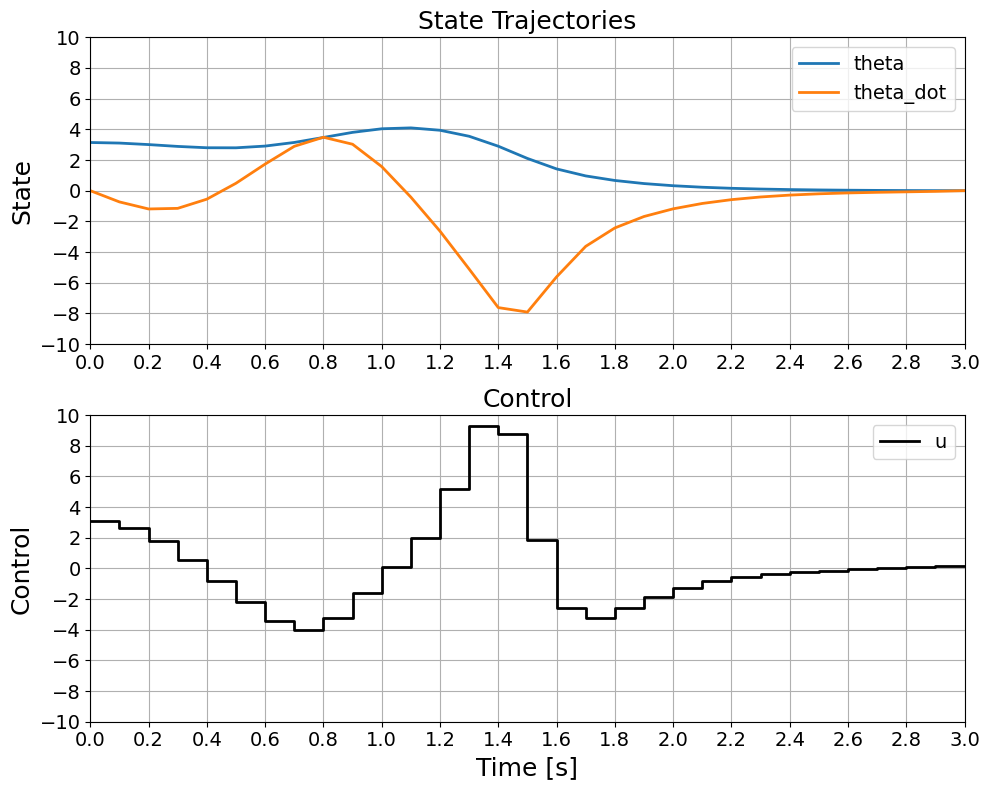

In [20]:
# Time grid for plotting
t_grid = np.linspace(0, T, N + 1)

# Extend the control signal for plotting
u_sol_extended = np.append(u_sol, u_sol[-1])

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the state trajectories on the first subplot
ax1.plot(t_grid, x_sol[0, :], label='theta', linewidth=2)
ax1.plot(t_grid, x_sol[1, :], label='theta_dot', linewidth=2)
#ax1.set_xlabel('Time [s]')
ax1.set_ylabel('State', fontsize=18)
ax1.set_xlim([0, T])
ax1.set_ylim([-10, 10])
ax1.legend(fontsize=14)
ax1.set_title('State Trajectories', fontsize=18)
ax1.grid()

# Set grid steps
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Plot the control trajectory on the second subplot
ax2.step(t_grid, u_sol_extended, 'k', label='u', where='post', linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=18)
ax2.set_ylabel('Control', fontsize=18)
ax2.set_xlim([0, T])
ax2.set_ylim([-10, 10])
ax2.legend(fontsize=14)
ax2.set_title('Control', fontsize=18)
ax2.grid()

# Set grid steps
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Set tick font size
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout
plt.tight_layout()
# plt.savefig('Figures/pendulum_swingup_single_shooting.pdf', format='pdf')

# Show the plots
plt.show()
